In [1]:
import clickhouse_connect

client = clickhouse_connect.get_client(
    host="clickhouse",
    port=8123,
    username="mewroo",
    password="mewroo",
    database="default",
)

client.command("SELECT version()")

'25.8.14.17'

In [5]:
client.query("SHOW TABLES FROM finance_yf").result_rows

[('dim_industry',),
 ('dim_ticker',),
 ('fact_market_cap',),
 ('fact_stock_prices',),
 ('industry_membership',),
 ('ingest_state',)]

In [6]:
tables = [
    "dim_industry",
    "industry_membership",
    "fact_market_cap",
    "fact_stock_prices",
    "ingest_state",
]

for t in tables:
    cnt = client.query(f"SELECT count(*) FROM finance_yf.{t}").result_rows[0][0]
    print(f"{t:25s} {cnt:,}")


dim_industry              290
industry_membership       2,682
fact_market_cap           1,467
fact_stock_prices         622,714
ingest_state              3,998


In [7]:
import pandas as pd

pd.DataFrame(
    client.query("""
        SELECT sector_key, industry_key, industry_name, industry_symbol, market_weight
        FROM finance_yf.dim_industry
        ORDER BY sector_key, industry_key
        LIMIT 20
    """).result_rows,
    columns=["sector_key", "industry_key", "industry_name", "industry_symbol", "market_weight"],
)

,sector_key,industry_key,industry_name,industry_symbol,market_weight
0,basic-materials,agricultural-inputs,Agricultural Inputs,^YH10110010,0.049670
1,basic-materials,agricultural-inputs,Agricultural Inputs,^YH10110010,0.049670
2,basic-materials,aluminum,Aluminum,^YH10150010,0.011416
3,basic-materials,aluminum,Aluminum,^YH10150010,0.011416
4,basic-materials,building-materials,Building Materials,^YH10120010,0.104736
5,basic-materials,building-materials,Building Materials,^YH10120010,0.104736
6,basic-materials,chemicals,Chemicals,^YH10130010,0.017231
7,basic-materials,chemicals,Chemicals,^YH10130010,0.017231
8,basic-materials,coking-coal,Coking Coal,^YH10160010,0.004713
9,basic-materials,coking-coal,Coking Coal,^YH10160010,0.004713


In [8]:
pd.DataFrame(
    client.query("""
        SELECT industry_key, countDistinct(ticker) AS n_stocks
        FROM finance_yf.industry_membership
        GROUP BY industry_key
        ORDER BY n_stocks DESC
        LIMIT 20
    """).result_rows,
    columns=["industry_key", "n_stocks"],
)


,industry_key,n_stocks
0,medical-devices,50
1,banks-regional,50
2,shell-companies,50
3,software-infrastructure,50
4,asset-management,50
5,software-application,50
6,aerospace-defense,50
7,biotechnology,50
8,specialty-industrial-machinery,50
9,semiconductors,47


In [9]:
pd.DataFrame(
    client.query("""
        SELECT sector_key, industry_key, ticker, ticker_name
        FROM finance_yf.industry_membership
        ORDER BY sector_key, industry_key
        LIMIT 20
    """).result_rows,
    columns=["sector_key", "industry_key", "ticker", "ticker_name"],
)


,sector_key,industry_key,ticker,ticker_name
0,basic-materials,agricultural-inputs,IPI,"Intrepid Potash, Inc."
1,basic-materials,agricultural-inputs,UAN,"CVR Partners, LP"
2,basic-materials,agricultural-inputs,SMG,The Scotts Miracle-Gro Company
3,basic-materials,agricultural-inputs,MOS,The Mosaic Company
4,basic-materials,agricultural-inputs,CF,"CF Industries Holdings, Inc."
5,basic-materials,agricultural-inputs,CTVA,"Corteva, Inc."
6,basic-materials,agricultural-inputs,FMC,FMC Corporation
7,basic-materials,aluminum,CSTM,Constellium SE
8,basic-materials,aluminum,CENX,Century Aluminum Company
9,basic-materials,aluminum,AA,Alcoa Corporation


In [10]:
pd.DataFrame(
    client.query("""
        SELECT
          countDistinct(ticker) AS tickers,
          min(ts) AS min_ts,
          max(ts) AS max_ts,
          count(*) AS rows
        FROM finance_yf.fact_stock_prices
    """).result_rows,
    columns=["tickers", "min_ts", "max_ts", "rows"],
)


,tickers,min_ts,max_ts,rows
0,2529,2025-01-06,2026-01-09,622714


In [11]:
pd.DataFrame(
    client.query("""
        SELECT ts, open, high, low, close, adj_close, volume
        FROM finance_yf.fact_stock_prices
        WHERE ticker = 'AAPL'
        ORDER BY ts DESC
        LIMIT 10
    """).result_rows,
    columns=["ts","open","high","low","close","adj_close","volume"],
)


,ts,open,high,low,close,adj_close,volume
0,2026-01-09,259.079987,260.209991,256.220001,259.369995,259.369995,39952300
1,2026-01-08,257.019989,259.290009,255.699997,259.040009,259.040009,50419300
2,2026-01-07,263.200012,263.679993,259.809998,260.329987,260.329987,48309800
3,2026-01-06,267.000000,267.549988,262.119995,262.359985,262.359985,52352100
4,2026-01-05,270.640015,271.510010,266.140015,267.260010,267.260010,45647200
5,2026-01-02,272.260010,277.839996,269.000000,271.010010,271.010010,37838100
6,2025-12-31,273.059998,273.679993,271.750000,271.859985,271.859985,27293600
7,2025-12-30,272.809998,274.079987,272.279999,273.079987,273.079987,22139600
8,2025-12-29,272.690002,274.359985,272.350006,273.760010,273.760010,23715200
9,2025-12-26,274.160004,275.369995,272.859985,273.399994,273.399994,21521800


In [12]:
pd.DataFrame(
    client.query("""
        SELECT ticker, market_cap, currency
        FROM finance_yf.fact_market_cap
        ORDER BY market_cap DESC
        LIMIT 10
    """).result_rows,
    columns=["ticker","market_cap","currency"],
)


,ticker,market_cap,currency
0,GOOG,3.973323e+12,USD
1,AAPL,3.832543e+12,USD
2,AMZN,2.644546e+12,USD
3,META,1.646056e+12,USD
4,TSLA,1.480023e+12,USD
5,BRK-B,1.076726e+12,USD
6,LLY,9.534356e+11,USD
7,WMT,9.131307e+11,USD
8,JPM,9.051915e+11,USD
9,V,6.750201e+11,USD


In [13]:
pd.DataFrame(
    client.query("""
        SELECT source, target, key, last_ts, last_asof_date
        FROM finance_yf.ingest_state
        ORDER BY updated_at DESC
        LIMIT 20
    """).result_rows,
    columns=["source","target","key","last_ts","last_asof_date"],
)

,source,target,key,last_ts,last_asof_date
0,yfinance,fact_stock_prices,YDDL|1d,2026-01-09,None
1,yfinance,fact_stock_prices,WM|1d,2026-01-09,None
2,yfinance,fact_stock_prices,MEG|1d,2026-01-09,None
3,yfinance,fact_stock_prices,RSG|1d,2026-01-09,None
4,yfinance,fact_stock_prices,GFL|1d,2026-01-09,None
5,yfinance,fact_stock_prices,LNZA|1d,2026-01-09,None
6,yfinance,fact_stock_prices,CWST|1d,2026-01-09,None
7,yfinance,fact_stock_prices,WCN|1d,2026-01-09,None
8,yfinance,fact_stock_prices,AQMS|1d,2026-01-09,None
9,yfinance,fact_stock_prices,CLH|1d,2026-01-09,None


In [14]:
pd.DataFrame(
    client.query("""
        SELECT
          countDistinct(m.ticker) AS membership_tickers,
          countDistinct(p.ticker) AS priced_tickers
        FROM finance_yf.industry_membership m
        LEFT JOIN finance_yf.fact_stock_prices p
          ON m.ticker = p.ticker
    """).result_rows,
    columns=["membership_tickers","priced_tickers"],
)


,membership_tickers,priced_tickers
0,2682,2530


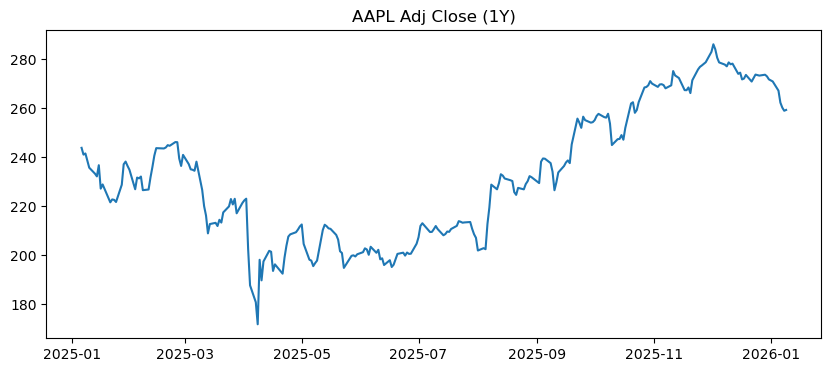

In [15]:
import matplotlib.pyplot as plt

df = pd.DataFrame(
    client.query("""
        SELECT ts, adj_close
        FROM finance_yf.fact_stock_prices
        WHERE ticker = 'AAPL'
        ORDER BY ts
    """).result_rows,
    columns=["ts","adj_close"],
)

plt.figure(figsize=(10,4))
plt.plot(df["ts"], df["adj_close"])
plt.title("AAPL Adj Close (1Y)")
plt.show()
